# Modeling seizure freedom (binary) using clinical data

## Import data

In [1]:
import pandas as pd

# Read dataframe from the pickle format
wide_df = pd.read_csv("../../data/processed/preprocessed_df.csv")

C:\Users\Amaury\AppData\Local\Temp\ipykernel_34932\4254179035.py:4: DtypeWarning: Columns (81,123,146,313,317,321,325,381,459,508,519,520,521,522,523,524,525,562,568,584,585,586,587,588,597,598,600,601,604,616,617,618,623,629,632,633,635,642,678,691,694,708,710,714,716,717,719,721,722,724,728,729,731,744,746,753,755,757,758,760,764,766,768,770,772,787,806,808,809,810,811,813,814,883,884,892,901,964,971,972,980,989,1052,1059,1060,1068,1076,1077,1140,1147,1165,1228,1236,1253,1323,1324,1341,1412,1429,1519,1536,1554,1674,1726,1734,1786,1797,1815,1826,1878,1886,1949,1950,1959,1978,2030,2038,2090,2130,2182,2190,2242,2253,2254,2263,2282,2334,2342,2394,2406,2415,2423,2434,2486,2494,2546,2558,2586,2638,2646,2698,2727,2738,2790,2798,2850,2862,2879,2881,2882,2895,2899,2908,2913,2925,2947,2973,2974,3112,3124,3172,3240,3301,3474,3475,3484,3488,3491,3584,3585,3624,3636,3640,3648,3837,3840,3852,3856,3858,3859,3863,3868,3873,3882,3883,3884,3966,3968,3973,3974,3977,3979,3982,3991,3992,3993,3994,3995,39

In [2]:
resective_procedures = ["resect_procedure___1", "resect_procedure___2", "resect_procedure___3",
                        "resect_procedure___4", "resect_procedure___5", "resect_procedure___6", "resect_procedure___7",
                        "resect_procedure___8", "resect_procedure___9", "resect_procedure___10", "resect_procedure___11",
                        "resect_procedure___12", "resect_procedure___13", "resect_procedure___14", "resect_procedure___15"]

test = wide_df[wide_df["resect_surg_other"].str.contains("shunt", case=False)==True][["record_id", "resect_surg_other"] + resective_procedures]
test.head(20)

,record_id,resect_surg_other,resect_procedure___1,resect_procedure___2,resect_procedure___3,resect_procedure___4,resect_procedure___5,resect_procedure___6,resect_procedure___7,resect_procedure___8,resect_procedure___9,resect_procedure___10,resect_procedure___11,resect_procedure___12,resect_procedure___13,resect_procedure___14,resect_procedure___15
43,RSCT007706,ICP monitor insertion; VA shunt removal; VP sh...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
72,RSCT013400,VNS shunt revision,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
144,RSCT026934,VP shunt revision & new implantation,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
285,RSCT051009,VP shunt insertion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
360,RSCT064527,Distal revision of VP shunt; replacement of lo...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
483,RSCT084731,VP shunt insertion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
497,RSCT086485,VP shunt revision,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
506,RSCT088227,"VP shunt revision, change of delta 1.0 valve t...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Select features

In [3]:
#wide_df["eo_date_clin_engel"] = pd.to_datetime(wide_df["eo_date_clin_engel"])
wide_df["resect_date"] = pd.to_datetime(wide_df["resect_date"], format='%m/%d/%Y', errors='coerce')

# Selecting patients who had their surgeries less than 5 years before EO assessment
wide_df = wide_df[wide_df["eo_days_postsurg"]<(365.25*5)]

X = wide_df[["sex_gender", "age", "eeg", "engel_outcomes", "mri", "phys_findings", "age_of_onset_hw", "eo_days_postsurg",
             "neuroanatomical_labeling", "neuropsychological_testing", "surg_stage", "neuro_findings", "eo_year_surg",
             "surgical_information", "freq_per_month_hw", "resect_procedure___1", "resect_procedure___2", "resect_procedure___3",
             "resect_procedure___4", "resect_procedure___5", "resect_procedure___6", "resect_procedure___7",
             "resect_procedure___8", "resect_procedure___9", "resect_procedure___10", "resect_procedure___11",
             "resect_procedure___12", "resect_procedure___13", "resect_procedure___14", "resect_procedure___15", "seizure_notes_word_cnt",
             "date_diff_surgical_information", "date_diff_eeg", "date_diff_neuropsychological_testing", "date_diff_mri"]]

epilepsy_diagnosis = ["epi_dx_category", "epi_seiz_symp_idio", "epi_seiz_med_refract", "epi_seiz_se", "epi_icd", "epi_dx"] # "epi_dx" and "epi_key_information" for term frequency // Hot-encode the rest

past_medical_history = ["pmh_allergies", "pmh_non_aeds", "pmh_explanation", "pmh_dev_delay"] # "pmh_surg" // all except pmh_dev_delay for term frequency

seizure_classification = ["seiz_onset_lat", "seiz_onset_zone___1", "seiz_onset_zone___2", "seiz_onset_zone___3",
                          "seiz_onset_zone___4", "seiz_onset_zone___5", "seizure_class___1", "seizure_class___2",
                          "seizure_class___3", "seizure_class___4"] # Categorize or tf "seiz_onset_zone_oth" // One-Hot encode "seiz_onset_lat"

aed_history = ["prev_aeds", "prev_aeds_num"] + [f"prev_aeds_name___{i}" for i in range(1, 40)]# One-hot encode "prev_aeds" // "prev_aeds_num" is continuous (scaling)

# Select the handwritten columns as final columns (manually checked and annotated)
X = X.rename(columns={"age_of_onset_hw": "age_of_onset",
                      "freq_per_month_hw": "freq_per_month"})

X = pd.concat([X, wide_df[epilepsy_diagnosis + seizure_classification]], axis=1)

# Fill NaN values with an empty string
X['epi_dx'] = X['epi_dx'].fillna('')

y = wide_df["surg_engel"]

# Turns the outcome variable from range [1,4] to [0,3]
y = y - 1

## One-hot encoding

One-hot encode the new columns from Epliepsy diagnosis information

In [4]:
# One-Hot Encoding for the first four columns
one_hot_encoded_df = pd.get_dummies(X, columns=["surg_stage", "epi_dx_category", "epi_seiz_symp_idio", "epi_seiz_med_refract", "epi_seiz_se", "seiz_onset_lat"]) # , "prev_aeds"

# Convert textual categorical variable to category type
X['epi_icd'] = X['epi_icd'].astype('category')

# One-Hot Encoding for 'epi_icd'
X = one_hot_encoded_df.join(pd.get_dummies(X['epi_icd'], prefix='epi_icd'))

X = X.drop("epi_icd", axis=1)

print(X.info())


<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 1 to 576
Data columns (total 92 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   sex_gender                            302 non-null    int64  
 1   age                                   302 non-null    float64
 2   eeg                                   302 non-null    float64
 3   engel_outcomes                        302 non-null    float64
 4   mri                                   302 non-null    float64
 5   phys_findings                         290 non-null    float64
 6   age_of_onset                          218 non-null    float64
 7   eo_days_postsurg                      302 non-null    float64
 8   neuroanatomical_labeling              302 non-null    float64
 9   neuropsychological_testing            302 non-null    float64
 10  neuro_findings                        289 non-null    float64
 11  eo_year_surg            

## Correlation matrix

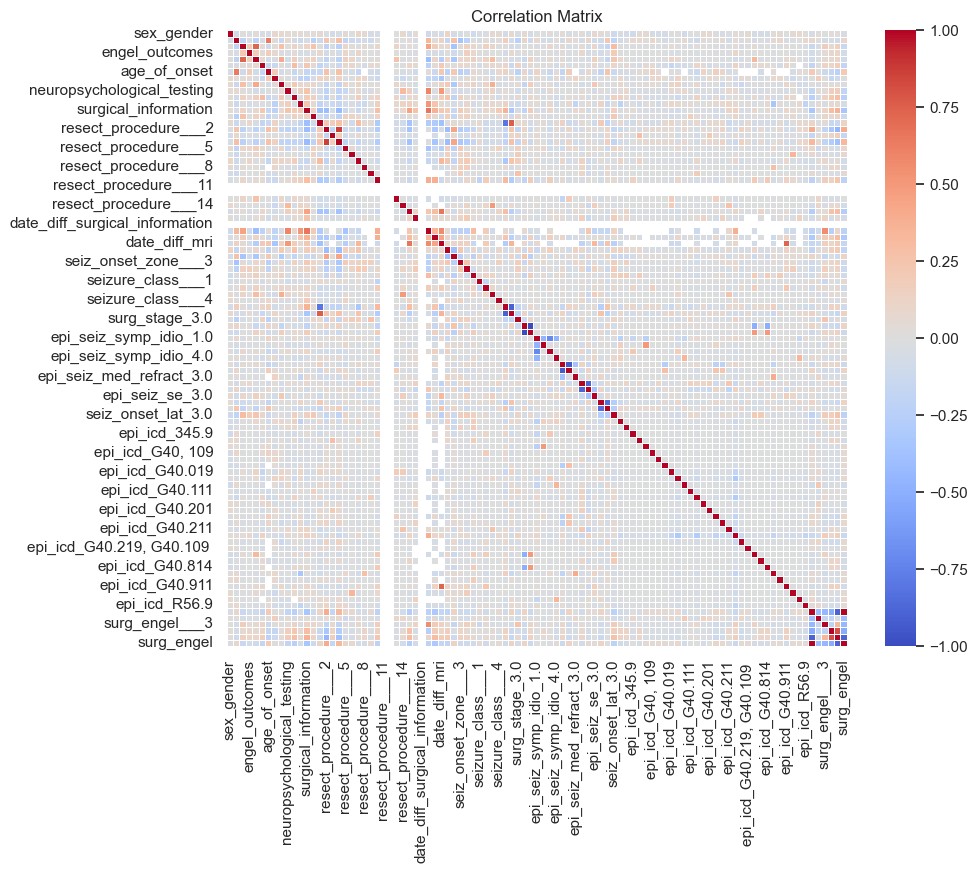

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

engel = wide_df[['surg_engel___1', 'surg_engel___2', 'surg_engel___3', 'surg_engel___4', 'surg_engel']]
engel = engel.rename(columns={'surg_engel': 'surg_engel_multi'})
y2 = y==0
engel = pd.concat([engel, y2], axis=1)

# Calculate the correlation matrix
correlation_matrix = pd.concat([X.drop("epi_dx", axis=1), engel], axis=1).corr()

# Create a heatmap using seaborn
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

### Check for high correlation variables

In [6]:
# Set a threshold for high correlation (e.g., 0.8 for 80%)
threshold = 0.8

# Find pairs of variables with a very high correlation
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Print the pairs of variables with a very high correlation
print(f"Pairs of variables with correlation above {threshold}:")
for pair in high_correlation_pairs:
    print(pair)
    
del correlation_matrix, threshold, high_correlation_pairs, pair, i, j

Pairs of variables with correlation above 0.8:
('resect_procedure___1', 'surg_stage_1.0')
('resect_procedure___2', 'resect_procedure___4')
('surg_stage_1.0', 'surg_stage_2.0')
('epi_dx_category_1.0', 'epi_dx_category_2.0')
('epi_seiz_med_refract_1.0', 'epi_seiz_med_refract_2.0')
('epi_seiz_se_1.0', 'epi_seiz_se_2.0')
('seiz_onset_lat_1.0', 'seiz_onset_lat_2.0')
('surg_engel___1', 'surg_engel_multi')
('surg_engel___1', 'surg_engel')
('surg_engel___4', 'surg_engel_multi')
('surg_engel_multi', 'surg_engel')


In [7]:
# Create a boolean mask for rows with different values
mask = engel["surg_engel"] != engel["surg_engel___1"]

# Filter the DataFrame based on the mask
rows_with_different_values = engel[mask]

# Display rows with different values
print("\nRows with different values:")
print(rows_with_different_values)


Rows with different values:
Empty DataFrame
Columns: [surg_engel___1, surg_engel___2, surg_engel___3, surg_engel___4, surg_engel_multi, surg_engel]
Index: []


## To transform from a multiclass prediction to a single class prediction

In [8]:
# Trying to predict Engel class I
y = y==0

## Split data into train/test

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Term frequency analysis

In [10]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Create and fit a CountVectorizer
count_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3))  # binary=True will set all non-zero counts to 1
count_vectorizer.fit(X_train["epi_dx"])

# Transform the training and test data
X_train_count = count_vectorizer.transform(X_train["epi_dx"])
X_test_count = count_vectorizer.transform(X_test["epi_dx"])

# Convert to DataFrame
X_train_count_df = pd.DataFrame(X_train_count.toarray(), columns=count_vectorizer.get_feature_names_out())
X_test_count_df = pd.DataFrame(X_test_count.toarray(), columns=count_vectorizer.get_feature_names_out())

# Count non-zero entries for each feature in the training data
non_zero_counts = np.count_nonzero(X_train_count_df, axis=0)

# Create a Series from the counts
non_zero_series = pd.Series(non_zero_counts, index=X_train_count_df.columns)

# Sort the Series in descending order and select top 20
top_20_features = non_zero_series.sort_values(ascending=False).head(20).index

# Select columns from the DataFrames based on top 20 features
X_train_top_20 = X_train_count_df[top_20_features]
X_test_top_20 = X_test_count_df[top_20_features]

# These DataFrames now contain only the top 20 features with 0/1 values
print(X_train_top_20.head())


   epilepsy  intractable  with  partial  seizures  partial seizures  \
0         1            0     0        0         0                 0   
1         1            0     0        0         0                 0   
2         1            1     1        1         1                 1   
3         1            1     1        1         1                 0   
4         1            1     1        1         1                 1   

   epilepsy with  focal  complex  complex partial  complex partial seizures  \
0              0      1        0                0                         0   
1              0      0        0                0                         0   
2              0      1        1                1                         1   
3              0      1        0                0                         0   
4              1      0        1                1                         1   

   with complex partial  with complex  partial epilepsy  status  related  \
0                     

In [11]:
# Remove the 'seizure_class_notes' column from X_train and X_test
X_train = X_train.drop('epi_dx', axis=1)
X_test = X_test.drop('epi_dx', axis=1)

# Filter out the top 10 TF-IDF features that have the same name as columns in X_train and X_test
common_columns = set(X_train.columns) & set(X_train_top_20.columns)
X_train_top_20_filtered = X_train_top_20.drop(columns=common_columns)
X_test_top_20_filtered = X_test_top_20.drop(columns=common_columns)

# Concatenate the filtered top 10 TF-IDF features with the modified X_train and X_test
X_train = pd.concat([X_train.reset_index(drop=True), X_train_top_20_filtered.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_top_20_filtered.reset_index(drop=True)], axis=1)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## 10-fold nested cross-validation

This step is done here in order to avoid data leakage of the scaling and imputing into the validation set used in the CV

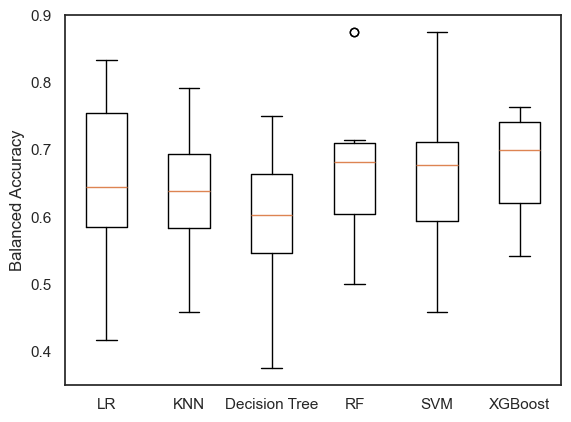

In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline

# List of continuous variables
numeric_var = ["age", "age_of_onset", "eo_days_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month",
               "date_diff_surgical_information", "date_diff_eeg",
               "date_diff_neuropsychological_testing", "date_diff_mri"] # , "prev_aeds_num"



column_names = numeric_var + list(set(X_train.columns) - set(numeric_var))

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Define models
models = {
    "LR": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(max_iter=2000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

results = []

# Loop through models
for model_name, model in models.items():
    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Create a stratified k-fold cross-validator
    kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

    # Cross-validate using the pipeline
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='balanced_accuracy', n_jobs=-1)

    # Append cross-validation results to the results list
    results.append(cv_results)

# Plot the results
plt.boxplot(results, labels=models.keys())
plt.ylabel('Balanced Accuracy')
plt.show()

### Nested CV with hyperparameter tuning

In the following, I plotted the AUC score for a few models after preprocessing, feature selection and hyperparameter tuning.

The inner CV is for hyperparameter tuning while the outer CV is for scoring.

c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1000 fits failed out of a total of 6250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Amau

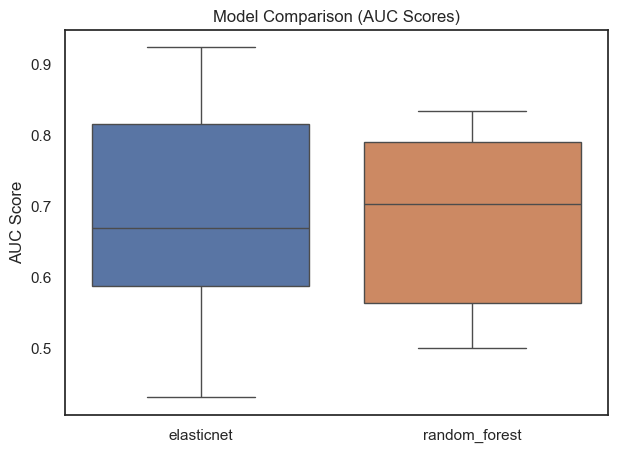

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import ElasticNet, LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from collections import Counter

X_CV = X_train.copy()
y_CV = y_train.copy()

# List of continuous variables
numeric_var = ["age", "age_of_onset", "eo_days_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month",
               "date_diff_surgical_information", "date_diff_eeg",
               "date_diff_neuropsychological_testing", "date_diff_mri"] # , "prev_aeds_num"

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Define model pipelines with named steps and feature selection
model_pipelines = {
    'elasticnet': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(ElasticNet(random_state=42))),
        ('model', ElasticNet())
    ]),
    'random_forest': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
        ('model', RandomForestClassifier())
    ])
    #'xgboost': Pipeline([
    #    ('preprocessor', preprocessor),
    #    ('feature_selection', SelectFromModel(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))),
    #    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    #])
    #'svm': Pipeline([
    #    ('preprocessor', preprocessor),
    #    ('feature_selection', SelectFromModel(SVC(kernel="linear", random_state=42))),
    #    ('model', SVC())
    #])
}

# Define hyperparameter grids for each model
models_and_parameters = {
    'elasticnet': {'feature_selection__estimator__alpha': np.linspace(0, 1, 5), 
                   'feature_selection__estimator__l1_ratio': np.linspace(0, 1, 5),
                   'model__alpha': np.linspace(0, 1, 5), 
                   'model__l1_ratio': np.linspace(0, 1, 5)},
    'random_forest': {'feature_selection__estimator__n_estimators': np.linspace(5, 120, 5, dtype=int), 
                      'model__n_estimators': np.linspace(5, 100, 5, dtype=int), 
                      'model__max_depth': np.linspace(2, 10, 5, dtype=int)}
    #'xgboost': {'feature_selection__estimator__n_estimators': np.linspace(5, 120, 5, dtype=int), 
    #            'model__n_estimators': np.linspace(5, 120, 5, dtype=int), 
    #            'model__learning_rate': np.logspace(-3, -1, 3)}
    #'svm': {'feature_selection__estimator__C': np.logspace(-3, 2, 6),
    #        'model__C': np.logspace(-3, 2, 6),
    #        'model__kernel': ['linear', 'rbf', 'poly'],
    #        'model__gamma': ['scale', 'auto']}
}

# Perform nested cross-validation and store selected features
outer_cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
inner_cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
results = {}
selected_features = {}
best_params = {}

for model_name, pipeline in model_pipelines.items():
    param_grid = models_and_parameters[model_name]
    auc_scores = []
    features_selected = []
    params = []

    for train_idx, test_idx in outer_cv.split(X_CV, y_CV):
        X_train_fold, X_test_fold = X_CV.iloc[train_idx], X_CV.iloc[test_idx]
        y_train_fold, y_test_fold = y_CV.iloc[train_idx], y_CV.iloc[test_idx]

        # Inner CV for hyperparameter tuning
        grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train_fold, y_train_fold)

        # Best model and parameters
        best_model = grid_search.best_estimator_
        params.append(grid_search.best_params_)

        # Evaluate on test set
        y_pred = best_model.predict(X_test_fold)
        auc_score = roc_auc_score(y_test_fold, y_pred)
        auc_scores.append(auc_score)

    results[model_name] = auc_scores
    best_params[model_name] = params

# Convert results to a DataFrame for easier plotting
all_scores = pd.DataFrame(results)

# Plot AUC scores
plt.figure(figsize=(7, 5))
sns.boxplot(data=all_scores)
plt.title('Model Comparison (AUC Scores)')
plt.ylabel('AUC Score')
plt.show()

In [16]:
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve

# List of continuous variables
numeric_var = ["age", "age_of_onset", "eo_days_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month",
               "date_diff_surgical_information", "date_diff_eeg",
               "date_diff_neuropsychological_testing", "date_diff_mri"] # , "prev_aeds_num"

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())

X_test_processed = preprocessor.transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Initialize LogisticRegressionCV
log_reg_cv = LogisticRegressionCV(l1_ratios=np.linspace(0, 1, 10),
                                  penalty='elasticnet',
                                  solver='saga',
                                  cv=cv,
                                  scoring="roc_auc",
                                  random_state=0,
                                  max_iter=10000,
                                  n_jobs=-1)

# Fit the model
log_reg_cv.fit(X_train_processed, y_train)

# Predict probabilities on the training set
y_train_pred_proba = log_reg_cv.predict_proba(X_train_processed)[:, 1]

# Compute AUC score on the training set
train_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f"Training AUC: {train_auc}")

# Coefficients plot
feature_names = X_train_processed.columns
coefficients = log_reg_cv.coef_.flatten()

Training AUC: 0.7919310344827586


In [21]:
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# List of continuous variables
numeric_var = ["age", "age_of_onset", "eo_days_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month",
               "date_diff_surgical_information", "date_diff_eeg",
               "date_diff_neuropsychological_testing", "date_diff_mri"] # , "prev_aeds_num"

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Define model pipelines with named steps and feature selection
pipeline = Pipeline([
        ('preprocessor', preprocessor),
        #('feature_selection', SelectFromModel(ElasticNet(random_state=42))),
        ('model', ElasticNet(max_iter=10000))
])

param_grid = {#'feature_selection__estimator__alpha': np.linspace(0, 1, 5),
              #'feature_selection__estimator__l1_ratio': np.linspace(0, 1, 5),
              'model__alpha': np.linspace(0, 1, 5),
              'model__l1_ratio': np.linspace(0, 1, 5)}

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Inner CV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_


# Predict probabilities on the training set
y_train_pred = best_model.predict(X_train)

# Compute AUC score on the training set
train_auc = roc_auc_score(y_train, y_train_pred)
print(f"Training AUC: {train_auc}")

# Evaluate on test set
y_pred = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, y_pred)
print(f"Test AUC: {test_auc}")


Training AUC: 0.7745620715917746
Test AUC: 0.6561085972850679


c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.773e+01, tolerance: 1.137e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


                    Feature  Coefficient  Abs_Coefficient
20     resect_procedure___2     0.681933         0.681933
10     surgical_information    -0.649264         0.649264
18           neuro_findings    -0.588750         0.588750
83          epi_icd_G40.219    -0.464535         0.464535
40        seizure_class___2    -0.336595         0.336595
..                      ...          ...              ...
52   epi_seiz_symp_idio_4.0     0.000000         0.000000
51   epi_seiz_symp_idio_3.0     0.000000         0.000000
50   epi_seiz_symp_idio_2.0     0.000000         0.000000
48      epi_dx_category_2.0     0.000000         0.000000
117     epileptic syndromes     0.000000         0.000000

[118 rows x 3 columns]


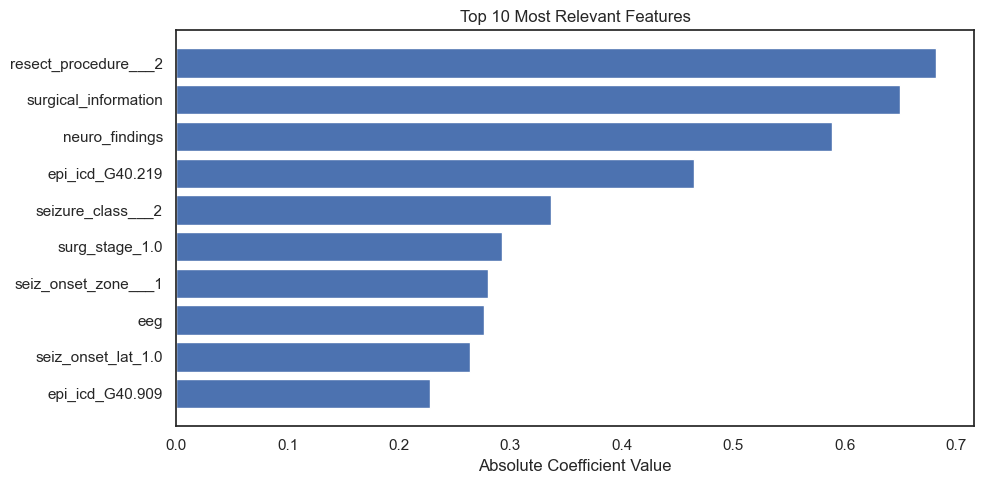

In [33]:
# Extract coefficients
coefficients = log_reg_cv.coef_.flatten()

# Create a DataFrame with feature names and coefficients
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Remove instances of "pipeline__" or "remainder__" in feature names
coeff_df['Feature'] = coeff_df['Feature'].apply(lambda x: x.replace("pipeline__", "").replace("remainder__", ""))


# Calculate the absolute value of the coefficients
coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()

# Sort the features by the absolute value of their coefficient
coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display the sorted DataFrame
print(coeff_df)

# Plotting the most relevant coefficients
plt.figure(figsize=(10, 5))
plt.barh(coeff_df['Feature'][:10], coeff_df['Abs_Coefficient'][:10])  # Adjust [:10] to display more or fewer features
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 10 Most Relevant Features')
plt.gca().invert_yaxis()  # To display the highest value at the top
plt.tight_layout()
plt.show()

In [36]:
from sklearn.metrics import classification_report

y_test_pred = log_reg_cv.predict(X_test_processed)

print(classification_report(y_test_pred, y_test))

              precision    recall  f1-score   support

       False       0.38      0.79      0.51        14
        True       0.91      0.62      0.73        47

    accuracy                           0.66        61
   macro avg       0.64      0.70      0.62        61
weighted avg       0.79      0.66      0.68        61



In [29]:
import shap

explainer = shap.KernelExplainer(grid_search.fit, X_test)
shap_values = explainer.shap_values(X_test_processed)

shap.summary_plot(shap_values, X_test_processed)

Provided model function fails when applied to the provided data set.


TypeError: Singleton array array(None, dtype=object) cannot be considered a valid collection.

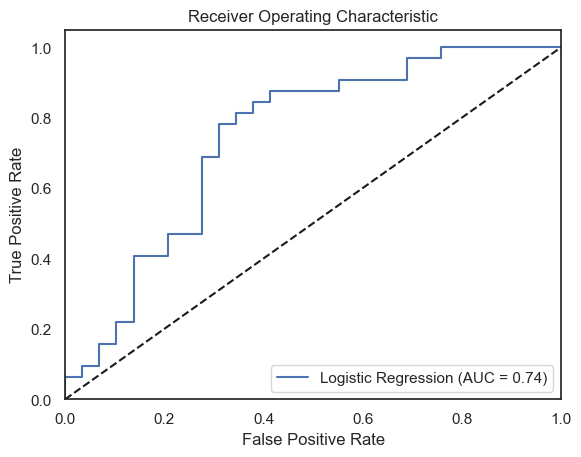

In [17]:
# Predict probabilities on the testing set
y_test_pred_proba = log_reg_cv.predict_proba(X_test_processed)[:, 1]

# Compute AUC score on the testing set
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Random Forest

In [33]:
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

# List of continuous variables
numeric_var = ["age", "age_of_onset", "eo_days_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month",
               "date_diff_surgical_information", "date_diff_eeg",
               "date_diff_neuropsychological_testing", "date_diff_mri"] # , "prev_aeds_num"

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())

X_test_processed = preprocessor.transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())

param_grid = {'n_estimators': np.linspace(5, 115, 15, dtype=int),
               'max_depth': np.linspace(2, 20, 10, dtype=int)}

clf = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

clf_cv = GridSearchCV(clf, param_grid,
                      cv=10,
                      scoring="roc_auc",
                      n_jobs=-1)

# Fit the model
clf_cv.fit(X_train_processed, y_train)

# Predict probabilities on the training set
y_train_pred_proba = clf_cv.predict_proba(X_train_processed)[:, 1]

# Compute AUC score on the training set
train_auc = roc_auc_score(y_train, y_train_pred_proba)
print(f"Training AUC: {train_auc}")

Training AUC: 0.9140689655172414


In [34]:
# Predict probabilities on the testing set
y_test_pred_proba = clf_cv.predict_proba(X_test_processed)[:, 1]

# Compute AUC score on the testing set
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Print AUC score on the testing set
print(f"Testing AUC: {test_auc}")

Testing AUC: 0.7952586206896551


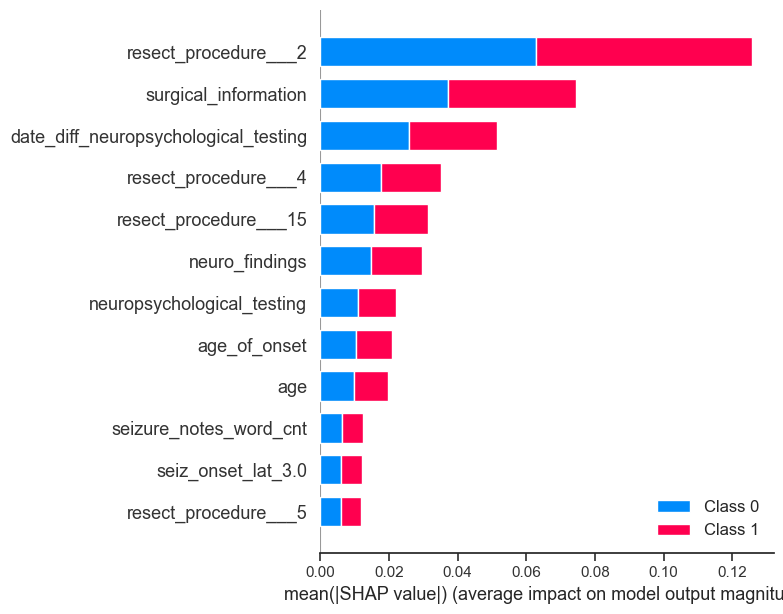

In [62]:
import shap

# Update column names by removing "remainder__" and "pipeline__" prefixes
#X_test_processed.columns = [col.replace("remainder__", "").replace("pipeline__", "") for col in X_test_processed.columns]


explainer = shap.TreeExplainer(clf_cv.best_estimator_)
shap_values = explainer.shap_values(X_test_processed)

shap.summary_plot(shap_values, X_test_processed, max_display=12)

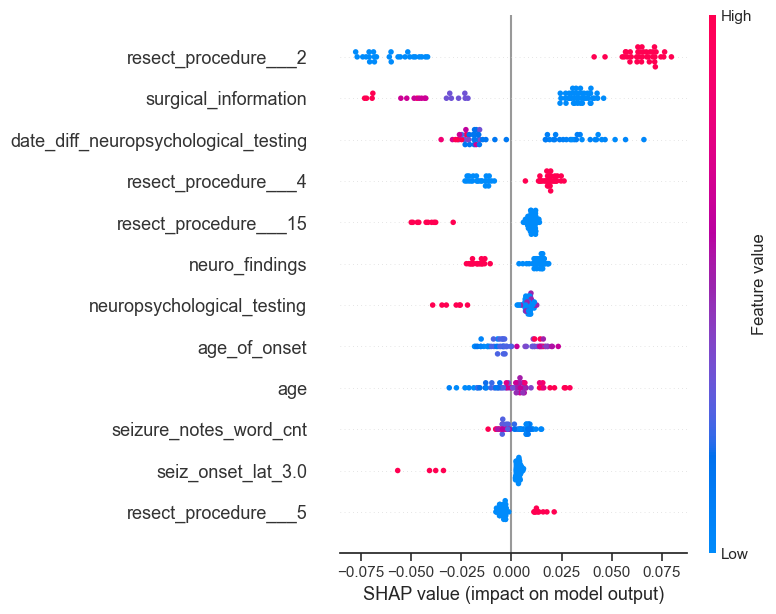

In [66]:
import shap

# Update column names by removing "remainder__" and "pipeline__" prefixes
#X_test_processed.columns = [col.replace("remainder__", "").replace("pipeline__", "") for col in X_test_processed.columns]


explainer = shap.TreeExplainer(clf_cv.best_estimator_)
shap_values = explainer.shap_values(X_test_processed)

shap.summary_plot(shap_values[1], X_test_processed, max_display=12)

In [35]:
from sklearn.metrics import classification_report

y_test_pred = clf_cv.predict(X_test_processed)

print(classification_report(y_test_pred, y_test))

              precision    recall  f1-score   support

       False       0.52      0.83      0.64        18
        True       0.91      0.67      0.77        43

    accuracy                           0.72        61
   macro avg       0.71      0.75      0.71        61
weighted avg       0.79      0.72      0.73        61



In [ ]:
def create_surg_group(nbr_surg):
    if nbr_surg == 1:
        return "Group 1"
    elif nbr_surg == 2:
        return "Group 2"
    else:
        return "Group 3"
    
def convert_columns_to_boolean(df, numeric_vars):
    for col in df.columns:
        if col not in numeric_vars:
            df[col] = df[col].astype(bool)
    return df

In [ ]:
import pandas as pd
from statsmodels.regression.mixed_linear_model import MixedLM

# List of continuous and non-continuous variables
numeric_var = ["age", "age_of_onset", "eo_yrs_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month"]  # , "prev_aeds_num"

# Variables in X_CV but not in numeric_var are treated as categorical
categorical_var = [col for col in X_train.columns if col not in numeric_var and col != 'y']


# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'))
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())

X_test_processed = preprocessor.fit_transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())

# Clean column names by removing 'pipeline__' and 'remainder__'
X_train_processed.columns = [col.replace('pipeline__', '').replace('remainder__', '') for col in X_train_processed.columns]
X_test_processed.columns = [col.replace('pipeline__', '').replace('remainder__', '') for col in X_test_processed.columns]

# Convert non-numeric columns to boolean in both X_train and X_test
X_train = convert_columns_to_boolean(X_train_processed, numeric_var)
X_test = convert_columns_to_boolean(X_test_processed, numeric_var)


X_train_processed["surgical_group"] = X_train_processed["surgical_information"].apply(create_surg_group).astype("category")

# Ensure your DataFrame (X_CV) includes the target variable y_CV
X_train_processed['surg_engel'] = y_train.copy()

# Construct the formula
#formula_parts = [f"C(Q('{var}'))" for var in categorical_var]
#formula_parts = [f"Q('{var}')" for var in numeric_var]
#formula = 'y ~ ' + ' + '.join(formula_parts)

formula = """surg_engel ~ age + age_of_onset + eo_yrs_postsurg + eo_year_surg + freq_per_month + 
C(sex_gender) + C(resect_procedure___2) + C(neuro_findings) + 
C(seiz_onset_zone___1) + eeg + 
neuropsychological_testing + phys_findings + C(seizure_class___2) + 
mri""".replace("\n", "")

# Define the model
groups_var = 'surgical_group'  # Random effects variable

model = MixedLM.from_formula(formula, groups=groups_var, data=X_train_processed)
result = model.fit()
print(result.summary())

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Assuming X_train_processed and y_train are already defined and preprocessed

# Add the grouping variable as a feature
# X_train_processed['surgical_group'] = X_train_processed['surgical_information'].apply(create_surg_group)

# Define your target variable and features
X = X_train_processed.drop('surg_engel', axis=1)  # Features
y = X_train_processed['surg_engel']  # Target variable

# Initialize the Random Forest model
# Note: Adjust n_estimators and other hyperparameters as needed
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X, y)

# Predict on the training set (or use a separate test set if available)
y_pred = rf_model.predict(X)

# Evaluate the model
print(classification_report(y, y_pred))
print("Accuracy:", accuracy_score(y, y_pred))

In [ ]:
X_train_processed['surg_engel'].dtype

In [ ]:
X_train_processed.info(verbose=True)

In [ ]:
from sklearn.metrics import roc_auc_score

# Predict probabilities for the positive class
y_pred_prob = result.predict(X_test_processed)  # Make sure this returns probabilities

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)

print(f'AUC: {auc}')

In [ ]:
X_CV.info(verbose=True)

na_counts = X_CV.isna().sum()
print(na_counts)

In [ ]:
import pandas as pd

# Set display options
pd.set_option('display.max_rows', None)  # Ensure all rows are displayed

# Calculate NA counts
na_counts = X_CV.isna().sum()

# Print the NA counts
print(na_counts)

# Reset the display option if you wish to return to the default setting
pd.reset_option('display.max_rows')

## Scale continuous variables

In [56]:
# Fit and transform on training and testing data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

## Null accuracy

In [57]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Create a DummyClassifier that always predicts the most frequent class
dummy_classifier = DummyClassifier(strategy='most_frequent')

# Fit the DummyClassifier on the training data
dummy_classifier.fit(X_train, y_train)

# Make predictions on the training data
y_pred_dummy = dummy_classifier.predict(X_train)

# Calculate null accuracy
null_accuracy = accuracy_score(y_train, y_pred_dummy)

print(f"Null Accuracy: {null_accuracy:.2f}")

Null Accuracy: 0.68


## ROC AND AUC

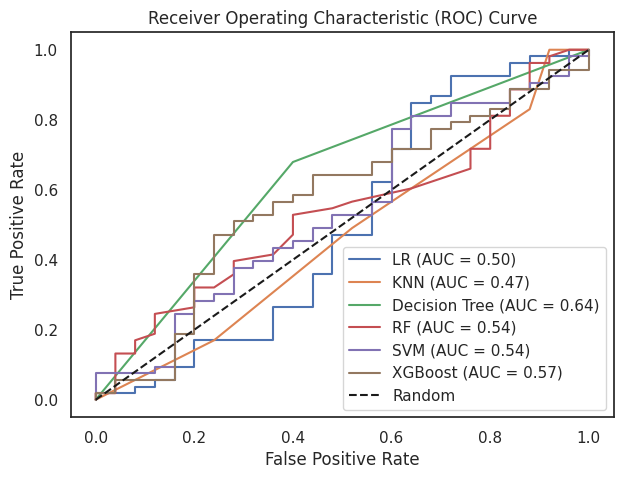

In [58]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    "LR": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(max_iter=2000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
}

plt.figure(figsize=(7, 5))

for name, model in models.items():
    # Fit the model on the training data
    model.fit(X_train_scaled, y_train)

    # Check if the model has predict_proba method
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # For models without predict_proba, use decision function
        y_pred_prob = model.decision_function(X_test_scaled)

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## Logistic Regression

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a Logistic Regression classifier
lr = LogisticRegression(max_iter=2000, random_state=42)

# Train the classifier on the training data
lr.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = lr.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.64


### Logistic Regression Coefficients

\begin{equation}
P(Y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1 + \beta_2x_2 + \ldots + \beta_nx_n)}}
\end{equation}

* Positive Coefficient: A positive coefficient for a feature means that an increase in that feature's value is associated with an increase in the log-odds of the response variable being in the positive class.

* Negative Coefficient: A negative coefficient for a feature means that an increase in that feature's value is associated with a decrease in the log-odds of the response variable being in the positive class.

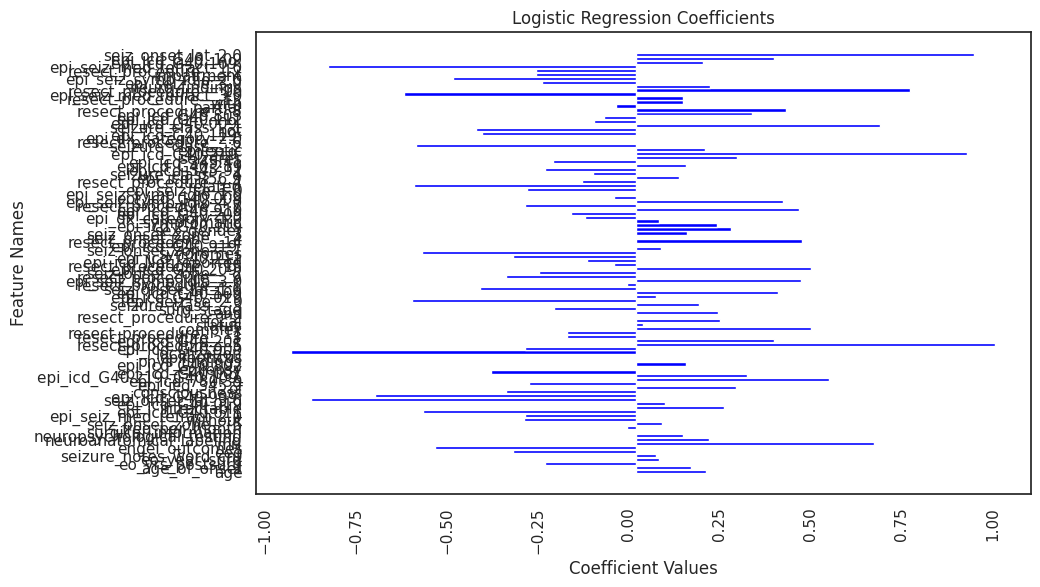

In [17]:
import numpy as np

# Get the coefficients and feature names
coefficients = lr.coef_.flatten()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(column_names, coefficients, color='blue')
plt.xlabel('Coefficient Values')
plt.ylabel('Feature Names')
plt.title('Logistic Regression Coefficients')
plt.xticks(rotation=90, ha="right")
plt.show()

In [18]:
# Get the intercept and coefficients
intercept = lr.intercept_[0]
coefficients = lr.coef_[0]

# Display the logistic regression equation
equation = f"P(Y=1) = 1 / (1 + e^(-({intercept:.4f} + "
for feature, coefficient in zip(numeric_var, coefficients):
    equation += f"{coefficient:.4f} * {feature} + "
equation = equation[:-2]  # Remove the trailing ' + '
equation += ")))"

print("Logistic Regression Equation:")
print(equation)


Logistic Regression Equation:
P(Y=1) = 1 / (1 + e^(-(1.9997 + 0.1922 * age + 0.1508 * age_of_onset + -0.2501 * eo_yrs_postsurg + 0.0628 * eo_year_surg + 0.0549 * seizure_notes_word_cnt + -0.3372 * eeg + -0.5529 * engel_outcomes + 0.6549 * mri + 0.2016 * neuroanatomical_labeling + 0.1285 * neuropsychological_testing + 0.0000 * surgical_information + -0.0256 * freq_per_month )))


### Feature selection

Shows important features by applying LASSO regression (L1 regularization) to penalize the absolute size of coefficients. This tends to shrink some coefficients to zero, effectively selecting a subset of features.

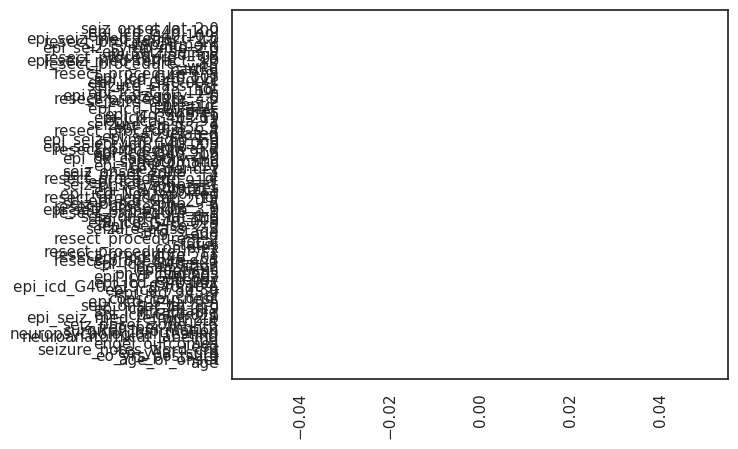

In [19]:
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pyplot as plt

lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X_train_scaled, y_train).coef_

# Filter out columns with coefficient equal to 0
nonzero_coef_indices = np.where(lasso_coef != 0)[0]
nonzero_names = [column_names[i] for i in nonzero_coef_indices]  # Use a list comprehension to get the names
nonzero_coef = lasso_coef[nonzero_coef_indices]

plt.barh(column_names, lasso_coef)
plt.xticks(rotation=90)
plt.show()

## Decision Tree classifier

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(max_depth = 3, random_state=42)

# Turn outcome variable into dummy variables
y_train_encoded = pd.get_dummies(y_train, columns=["surg_engel"], drop_first=True)
y_test_encoded = pd.get_dummies(y_test, columns=["surg_engel"], drop_first=True)

# Train the classifier on the training data
clf.fit(X_train, y_train_encoded)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.56


### Plot decision tree

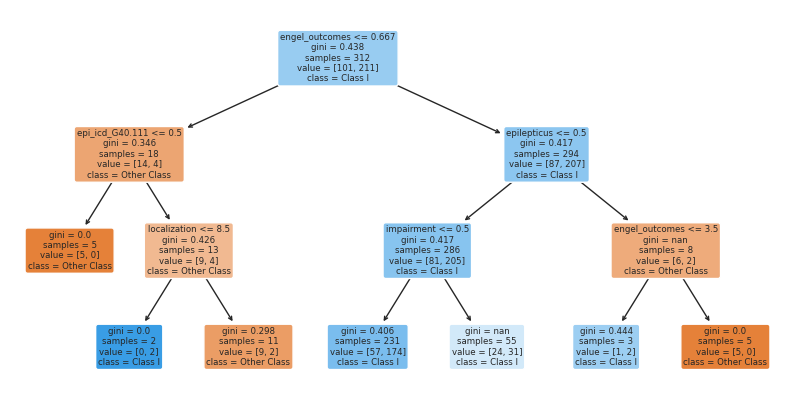

In [21]:
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(10, 5))
plot_tree(clf, filled=True, feature_names=column_names, class_names=["Other Class", "Class I"], rounded=True)
plt.show()

## Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.64


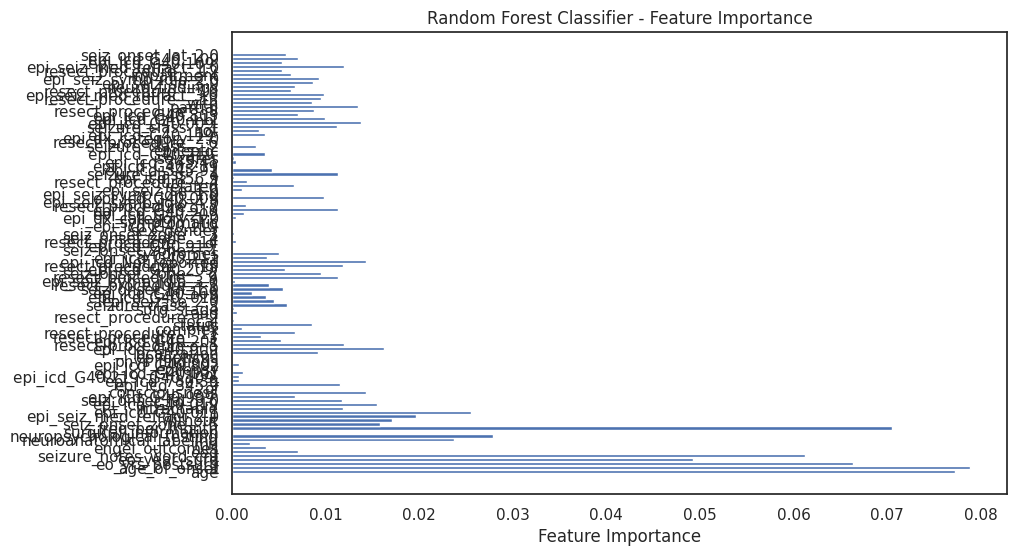

In [23]:
# Get feature importances from the trained Random Forest model
feature_importances = rf.feature_importances_

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align="center")
plt.yticks(range(len(feature_importances)), column_names)
plt.xlabel("Feature Importance")
plt.title("Random Forest Classifier - Feature Importance")
plt.show()

## Support Vector Machines (SVM)

In [24]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an SVM classifier
svc = SVC(kernel='linear', C=1, random_state=42)

# Train the classifier on the training data
svc.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = svc.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.69


Positive coefficients indicate that the corresponding features are positively correlated with the target class, while negative coefficients indicate a negative correlation.

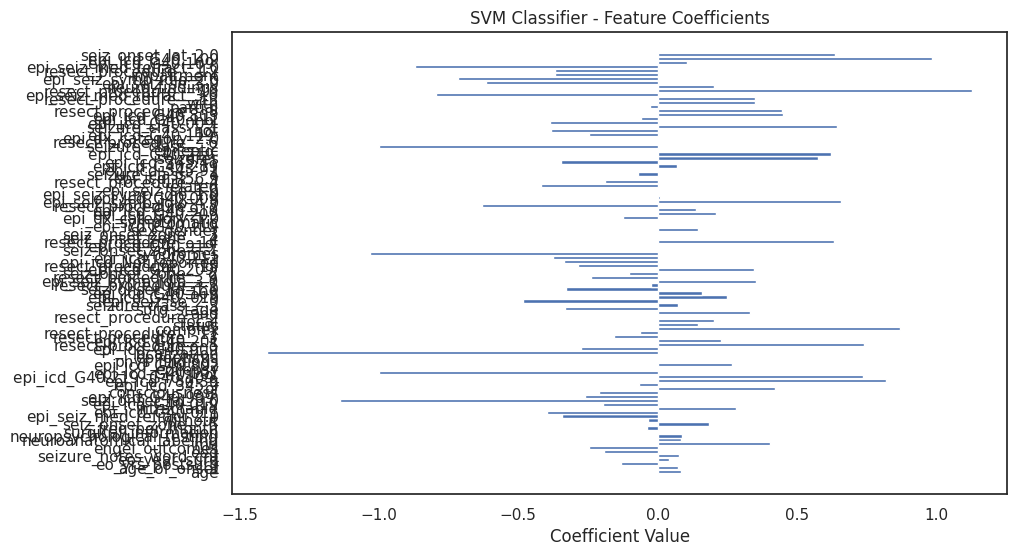

In [25]:
# Get the coefficients (weights) from the trained SVM model
coefficients = svc.coef_.flatten()

# Create a bar plot of feature coefficients
plt.figure(figsize=(10, 6))
plt.barh(range(len(coefficients)), coefficients, align="center")
plt.yticks(range(len(coefficients)), column_names)
plt.xlabel("Coefficient Value")
plt.title("SVM Classifier - Feature Coefficients")
plt.show()

In [26]:
(X_train["engel_outcomes"]==2).sum()

3

## XGBoost

In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Create an XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Train the classifier on the training data
xgb.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = xgb.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.63


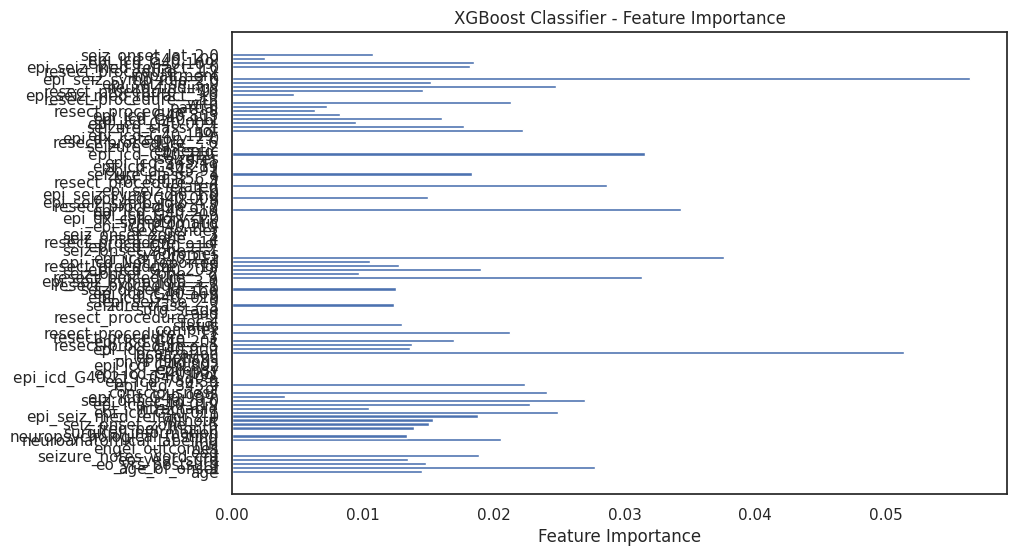

In [28]:
# Get feature importances from the trained XGBoost model
feature_importances = xgb.feature_importances_

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align="center")
plt.yticks(range(len(feature_importances)), column_names)
plt.xlabel("Feature Importance")
plt.title("XGBoost Classifier - Feature Importance")
plt.show()

## Neural Network

In [29]:
import tensorflow as tf

# Create a simple neural network model using Keras for binary classification
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training data
model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Make predictions on the test data
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


2024-01-15 16:46:50.339971: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 16:46:50.413702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 16:46:50.413785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 16:46:50.419597: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 16:46:50.443370: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 16:46:50.444237: I tensorflow/core/platform/cpu_feature_guard.cc:1

Epoch 1/5
8/8 - 1s - loss: 0.6778 - accuracy: 0.5663 - val_loss: 0.6402 - val_accuracy: 0.6984 - 1s/epoch - 169ms/step
Epoch 2/5
8/8 - 0s - loss: 0.6427 - accuracy: 0.6707 - val_loss: 0.6093 - val_accuracy: 0.6984 - 59ms/epoch - 7ms/step
Epoch 3/5
8/8 - 0s - loss: 0.6226 - accuracy: 0.6707 - val_loss: 0.6029 - val_accuracy: 0.6984 - 51ms/epoch - 6ms/step
Epoch 4/5
8/8 - 0s - loss: 0.6132 - accuracy: 0.6707 - val_loss: 0.5971 - val_accuracy: 0.6984 - 62ms/epoch - 8ms/step
Epoch 5/5
8/8 - 0s - loss: 0.6031 - accuracy: 0.6747 - val_loss: 0.5941 - val_accuracy: 0.6825 - 59ms/epoch - 7ms/step
3/3 [==============================] - 0s 4ms/step
Accuracy: 0.68


## Perform PCA

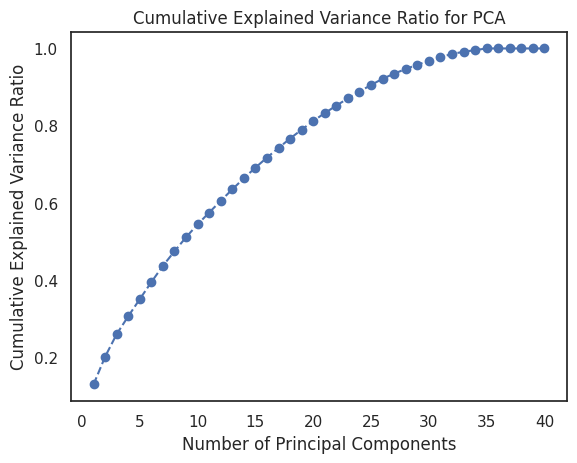

In [30]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Extract numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can use other strategies like 'median' or 'most_frequent'
numerical_features_imputed = pd.DataFrame(imputer.fit_transform(numerical_features), columns=numerical_features.columns)

# Data preprocessing (standardization)
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features_imputed)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(numerical_features_scaled)

# Plot explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio for PCA')
plt.show()

In [31]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

X2 = wide_df.drop(["surg_engel", "surg_engel___1", "surg_engel___2", "surg_engel___3",
                   "surg_engel___4", "engel_class1", "engel_class2", "engel_class3",
                   "engel_class4",], axis=1)
# Extract numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numerical_features, y, test_size=0.2, random_state=42)

# Impute missing values separately for training and testing sets
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Data preprocessing (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Perform PCA
pca = PCA(n_components=20)  # Choose the number of components based on your analysis
pca_result_train = pca.fit_transform(X_train_scaled)
pca_result_test = pca.transform(X_test_scaled)

# Create a Support Vector Machine
svc = SVC(kernel='linear', C=1.0, random_state=42)

# Train the classifier on the training data
svc.fit(pca_result_train, y_train)

# Make predictions on the test data
y_pred = svc.predict(pca_result_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.63


## Print system information

In [ ]:
import session_info

session_info.show()

KeyError: 'pybind11_abseil'